In [144]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# **Data Loading and Exploration**

**Data Loading**

 The data is loaded as **train_ds** *(for training set)*, **val_ds** *(for validation set)* and **test_ds** *(for test set)*

In [6]:
train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

Examining the size of each set

In [7]:
train_size = tf.data.experimental.cardinality(train_ds).numpy()
val_size = tf.data.experimental.cardinality(val_ds).numpy()
test_size = tf.data.experimental.cardinality(test_ds).numpy()

print("Training set size:", train_size)
print("Validation set size:", val_size)
print("Test set size:", test_size)

Training set size: 19291
Validation set size: 4133
Test set size: 4134


Visualize the training set.

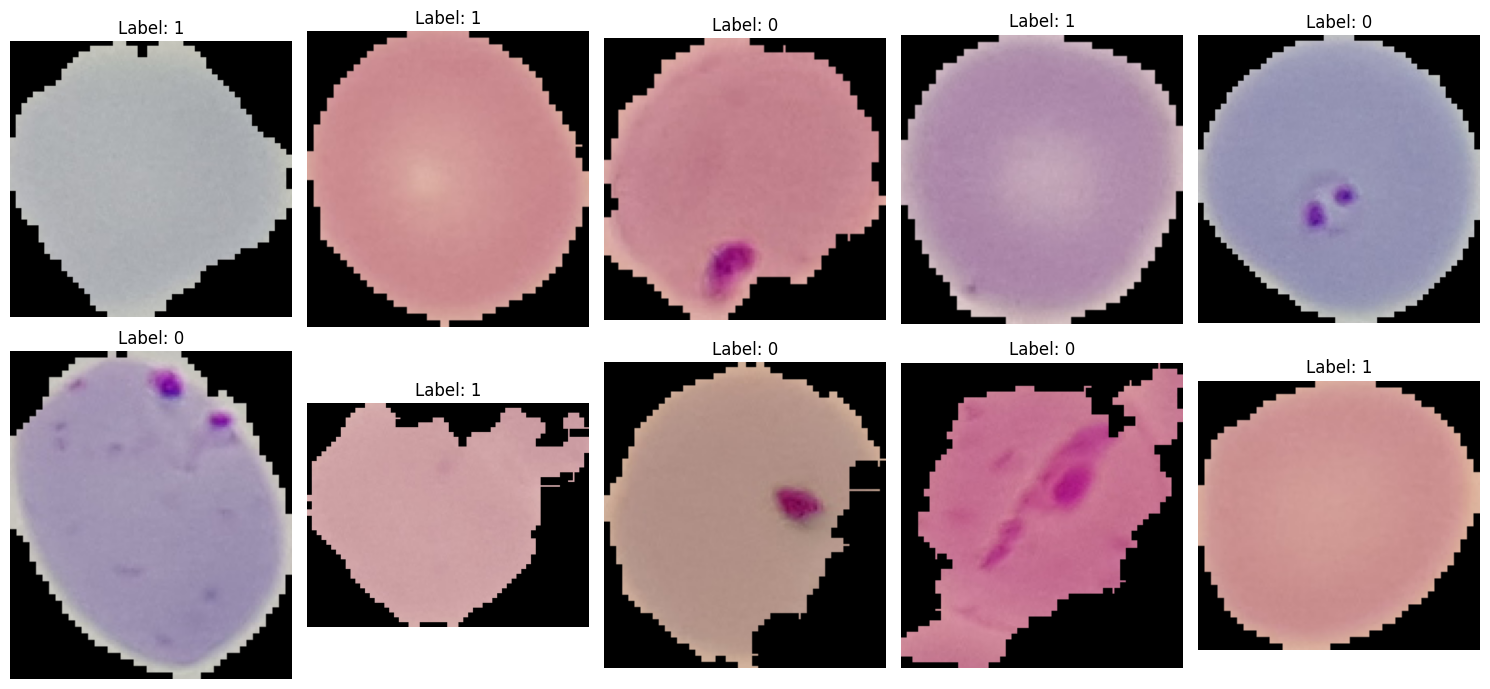

In [134]:
num_examples = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 7))

# Iterate over the dataset and plot each example
for i, (image, label) in enumerate(train_ds.take(num_examples)):
    row = i // 5
    col = i % 5
    
    # Plot the image
    axes[row, col].imshow(image.numpy())
    axes[row, col].set_title(f"Label: {label.numpy()}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [2]:
print('# Examine the shape')
print('  ==================')

for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    


> The images have different shapes as seen above.
> They need to be preprocessed before model training.

# **Preprocessing Pipeline**

In [10]:
# This is the target image size
image_size = [128, 128]

# Convert the image data type
def convert_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

# Pad the images
def padding(image,label):
    image,label = convert_image(image, label)
    image = tf.image.resize_with_crop_or_pad(image,image_size[0] ,image_size[1])
    return image,label

# The final preprocessing pipeline
def pipeline(image, label):
    image, label = padding(image, label)
    return image, label

In [11]:
BATCH_SIZE = 32
preprocessed_train_ds  = (
    train_ds
    .cache()
    .map(pipeline)
    .batch(BATCH_SIZE)
) 

preprocessed_val_ds = (
    val_ds
    .cache()
    .map(pipeline)
    .batch(BATCH_SIZE)
) 

preprocessed_test_ds = (
    val_ds
    .cache()
    .map(pipeline)
    .batch(BATCH_SIZE)
) 

In [12]:
image_batch, label_batch = next(iter(preprocessed_train_ds))

def show_preprocessed_data(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(5):
        ax = plt.subplot(1,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

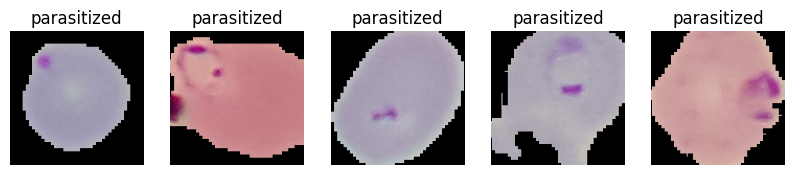

In [13]:
show_preprocessed_data(image_batch.numpy(), label_batch.numpy())

# The output images are of the same sizes, i.e (128, 128, 3)

# **Model Architecture**

In [96]:
# Define the CNN model
def malaria_cnn(input_shape, dropout_rate=0.2):
    model = Sequential([
        # Convolutional layers
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Flatten layer to feed into dense layers
        Flatten(),
        
        # Dense and Dropout layers
        Dense(512, activation='relu'),
        Dropout(dropout_rate), 
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Output layer with sigmoid activation for binary classification
    ])
    return model

In [97]:
input_shape = (128, 128, 3)  # Input shape of the images after preprocessing
learning_rate=0.001
batch_size = 64

In [98]:
# CNN model
model = malaria_cnn(input_shape)

In [99]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
              metrics=['accuracy', 'auc'])

In [100]:
# Display the model summary
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,338,689 (8.92 MB)

 Trainable params: 2,338,689 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

# **Model Training**

In [101]:
# Train the model
history = model.fit(preprocessed_train_ds, epochs=8, batch_size=batch_size, validation_data=preprocessed_val_ds)

Epoch 1/8
  7/603 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.5098 - auc: 0.5347 - loss: 0.6882

W0000 00:00:1715605507.834148     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6927 - auc: 0.7685 - loss: 0.5093

W0000 00:00:1715605521.464500     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715605522.218622     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


603/603 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.6930 - auc: 0.7687 - loss: 0.5090 - val_accuracy: 0.9514 - val_auc: 0.9833 - val_loss: 0.1594
Epoch 2/8
  9/603 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9692 - auc: 0.9956 - loss: 0.1090

W0000 00:00:1715605523.298115     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9514 - auc: 0.9800 - loss: 0.1602 - val_accuracy: 0.9538 - val_auc: 0.9872 - val_loss: 0.1426
Epoch 3/8
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9560 - auc: 0.9842 - loss: 0.1423 - val_accuracy: 0.9548 - val_auc: 0.9884 - val_loss: 0.1384
Epoch 4/8
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9566 - auc: 0.9857 - loss: 0.1371 - val_accuracy: 0.9543 - val_auc: 0.9883 - val_loss: 0.1362
Epoch 5/8
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9560 - auc: 0.9878 - loss: 0.1281 - val_accuracy: 0.9519 - val_auc: 0.9874 - val_loss: 0.1432
Epoch 6/8
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9599 - auc: 0.9904 - loss: 0.1153 - val_accuracy: 0.9550 - val_auc: 0.9882 - val_loss: 0.1412
Epoch 7/8
603/603 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9625 - auc: 0.9914 - loss: 0.1098 - val_accuracy: 0.9545 - val_auc: 0.9865 - val_loss: 0.1497
Epoch 8/8
603/603 ━━━━━━━━━━━━━━━━━━━━ 9s 16

# **Model Evaluation**

In [147]:
# Evaluate the model on the test set
# test_loss, test_accuracy = 
eval_ = model.evaluate(preprocessed_test_ds)
print()
print("Model Evaluation")
print("================")
print(f"Model Accuracy: {eval_[1]}")
print(f"Area Under Curve (AUC):  {eval_[2]}")
print(f"Model Loss (Binary CrossEntropy Loss): {eval_[0]}")

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9497 - auc: 0.9809 - loss: 0.1823

Model Evaluation
Model Accuracy: 0.9501572847366333
Area Under Curve (AUC):  0.9823569655418396
Model Loss (Binary CrossEntropy Loss): 0.17916545271873474


**Training Curves**

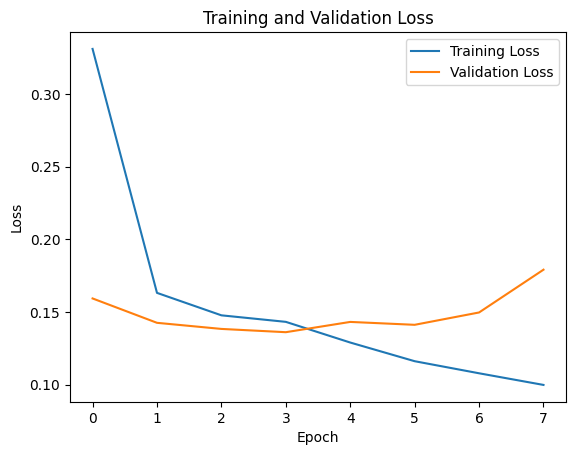

In [111]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

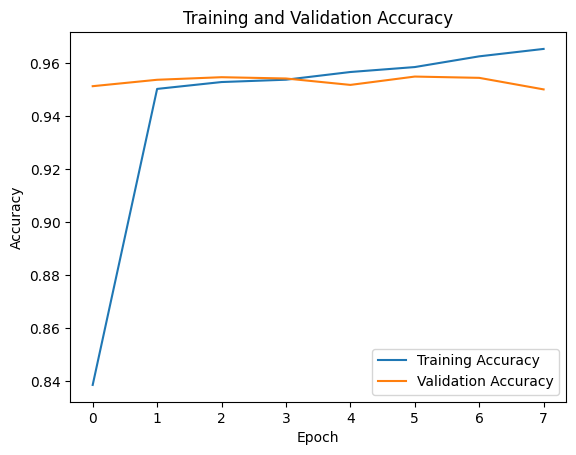

In [112]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**ROC Curve**

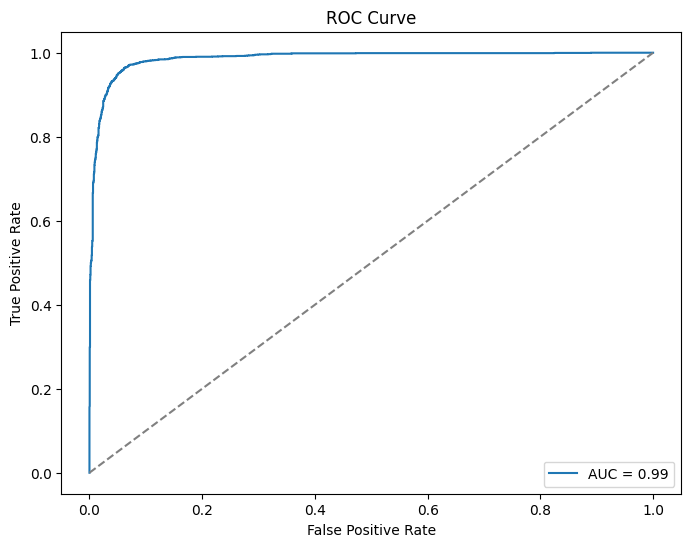

In [140]:
# Concatenate the labels from preprocessed_test_ds into a single array
y_true = np.concatenate([y for x, y in preprocessed_test_ds], axis=0)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, predictions)
auc = roc_auc_score(y_true, predictions)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Confusion Matrix**

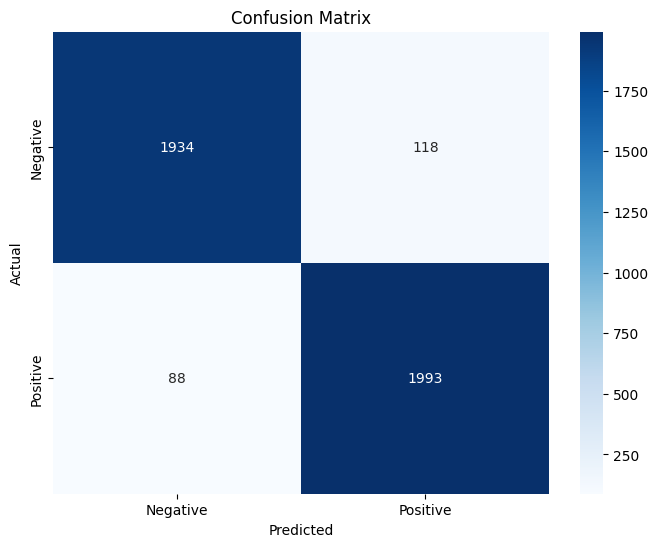

In [145]:
# Concatenate the labels from preprocessed_test_ds into a single array
y_true = np.concatenate([y for x, y in preprocessed_test_ds], axis=0)

# Convert predictions to binary values (0 or 1) based on a threshold (e.g., 0.5)
binary_predictions = np.where(predictions > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(y_true, binary_predictions)

# Define class labels
class_labels = ['Negative', 'Positive']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# **Model Testing**

In [131]:
# Make predictions on the test set
predictions = model.predict(preprocessed_test_ds)

# Convert predictions to binary values (0 or 1) based on the threshold (0.5)
binary_predictions = np.where(predictions > 0.5, 1, 0)

130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [132]:
#   1. Convert predictions to binary values (0 or 1) based on a threshold (0.5)
binary_predictions = np.where(predictions > 0.5, 1, 0)

#   2. Display the predictions of the first 10 images of the test data
print(binary_predictions[0:10])

[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]]


# **Model Saving**

In [ ]:
# # Specify the file path where you want to save the model
# model_path = '/kaggle/working/malaria_cell_model.h5'


# # Save the model
# model.save(model_path)

# print("Model saved successfully at:", model_path)

# **Loading Saved Model**

In [133]:
# Specify the file path where the model is saved
model_path = '/kaggle/working/malaria_cell_model.h5' # Adjust the file path if needed

# Load the saved model
malaria_model = load_model(model_path)

# Now you can use the loaded model for predictions or further training

# Example: Make predictions using the loaded model
prediction = malaria_model.predict(preprocessed_test_ds)


#   1. Convert predictions to binary values (0 or 1) based on a threshold (0.5)
binary_prediction = np.where(prediction > 0.5, 1, 0)

#   2. Display the predictions of the first 10 images of the test data
print(binary_prediction[0:10])

 28/130 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

W0000 00:00:1715609940.229757     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
[[1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]]


W0000 00:00:1715609941.116152     131 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
